# Introduction

Le but de ce projet est de mettre en place un Generative Adversarial Network (GAN) qui va utiliser une base de donnée contenant des images de chiffre afin d'en générer artificiellement.

In [2]:
import keras
from keras import layers, models
import numpy as np

latent_dim = 50
height, width = 28, 28
channels = 1

Les données sont en noir et blanc et de dimension 28 x 28. On met en place un espace latent qui servira de socle pour la génération de données. Il est de dimension 28.

# Modèle génératif

La première étape dans la confection du GAN est la mise en place d'un modèle qui, à partir de données prises aléatoirement dans un espace latent, va générer une image ayant les mêmes caractéristiques que la base de donnée, et dont le but sera d'y ressembler le plus fidèlement possible.

In [3]:
model_generator = models.Sequential()

# Element de l'espace latent -> carte de caractéristiques 7x7 de 128 canaux
model_generator.add(layers.Dense(128*7*7, input_dim=latent_dim))
model_generator.add(layers.Reshape((7, 7, 128)))

model_generator.add(layers.Conv2D(256, 5, padding='same'))
model_generator.add(layers.LeakyReLU(alpha=0.2))

# Sur-échantillonnage -> 14x14
model_generator.add(layers.Conv2DTranspose(256, 4, strides=2, padding='same'))
model_generator.add(layers.LeakyReLU(alpha=0.2))

# Sur-échantillonnage -> 28x28
model_generator.add(layers.Conv2DTranspose(256, 4, strides=2, padding='same'))
model_generator.add(layers.LeakyReLU(alpha=0.2))

model_generator.add(layers.Conv2D(256, 5, padding='same'))
model_generator.add(layers.LeakyReLU(alpha=0.2))

model_generator.add(layers.Conv2D(256, 5, padding='same'))
model_generator.add(layers.LeakyReLU(alpha=0.2))

# -> carte de caractéristiques 28x28
model_generator.add(layers.Conv2D(channels, 7, activation='tanh', padding='same'))

La toute première couche va prendre des valeurs aléatoires dans l'espace latent pour créer 128 cartes de caractéristiques de taille 14x14. Les étapes suivantes vont ensuite travailler là dessus pour générer en tout 256 cartes de caractéristiques de taille 28x28. Enfin, la dernière couche va rassembler toutes ces couches pour finalement obtenir une image de taille 28x28 générée entièrement.

In [3]:
model_generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              319872    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 256)         819456    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 256)      1048832   
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 256)       0         
                                                        

Détails techniques :
- Couche Conv2DTranspose: couche cherchant à augmenter la taille de la donnée en terme de dimension height x width. Fonctionne un peu comme l'opposé de la couche 'Conv2D', avec un noyau qui s'applique à un pixel pour en faire cette fois ci plusieurs nouveaux pixels, créés par une opération de convolution.
- Couche LeakyReLU: Couche ReLU avec cependant une fonction de la forme $f(x) = ax, \ a \in \mathbb{R}^*_+$ lorsque $x<0$ (pour les fonctions ReLU classique, on a plutôt $f(x) = 0$ pour $x<0$). Cette fonction donne de meilleurs résultats en général (voir : https://arxiv.org/pdf/1505.00853.pdf ))
- Pour les modèles génératif, la fonction 'tanh' en dernière fonction d'activation est plus pratique que d'utiliser la fonction sigmoïde.

Ces détails permettent en général d'éviter la propriété 'sparsity' (plusieurs poids =0, ce qui simplifie les calculs), qui est le fait d'avoir des gradients creux, habituellement une propriété souhaitable.

# Modèle Discriminatoire

Le second modèle constituant le GAN est un modèle qui va chercher à différencier une image appartenant à la base de données a une image générée aléatoirement (par le modèle génératif donc). C'est un modèle plus classique qui à déjà été vu précédemment. 

In [4]:
model_discriminator = models.Sequential()

# Image de la forme (28, 28, 1) -> Classification binaire (faux/authentique)
model_discriminator.add(layers.Conv2D(128, 3, input_shape=(height, width, channels)))
model_discriminator.add(layers.LeakyReLU(alpha=0.2))
model_discriminator.add(layers.Dropout(0.4))

model_discriminator.add(layers.Conv2D(128, 4, strides=2))
model_discriminator.add(layers.LeakyReLU(alpha=0.2))
model_discriminator.add(layers.Dropout(0.4))

model_discriminator.add(layers.Conv2D(128, 4, strides=2))
model_discriminator.add(layers.LeakyReLU(alpha=0.2))
model_discriminator.add(layers.Dropout(0.4))

model_discriminator.add(layers.Conv2D(128, 4, strides=2))
model_discriminator.add(layers.LeakyReLU(alpha=0.2))
model_discriminator.add(layers.Dropout(0.4))

model_discriminator.add(layers.Flatten())

# Classifieur
model_discriminator.add(layers.Dense(1, activation='sigmoid'))

In [5]:
model_discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 128)       1280      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 26, 26, 128)       0         
                                                                 
 dropout (Dropout)           (None, 26, 26, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)       262272    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 12, 12, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 5, 5, 128)        

In [6]:
from tensorflow.keras import optimizers

discriminator_optimizer = optimizers.RMSprop(
    learning_rate=0.0008,
    clipvalue=1.0, # Troncation des gradients
    decay=1e-8 # Dégradation du taux d'apprentissage (stabilise l'entrainement)
)

In [7]:
model_discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

# Modèle Antagoniste

On peut finalement créer le modèle GAN qui assemble les deux modèles précédents. Le gros point de ce modèle est qu'il est essentiellement conçu afin que le modèle génératif réussisse à tromper le modèle discriminant. 

In [8]:
model_discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = model_discriminator(model_generator(gan_input))

# Point de l'espace latent -> Décision de classification
model_gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = optimizers.RMSprop(
    learning_rate=0.0004, 
    clipvalue=1.0, 
    decay=1e-8
)

model_gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [9]:
model_gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         6526849   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 788225    
                                                                 
Total params: 7,315,074
Trainable params: 6,526,849
Non-trainable params: 788,225
_________________________________________________________________


Entraîner le réseau :
- Tirer des points dans l'espace latent
- Générer les images associées
- Mélanger ces images avec des images authentiques
- Entraîner le réseau discriminant avec ce lot d'images
- Tirer des nouveaux points dans l'espace latent
- Y associer des étiquettes "authentique" afin de mettre à jour les poids du générateur dans le bon sens du terme.

# Mise en oeuvre

Il est désormais possible de mettre en place le modèle sur une base de donnée.
Ici, on choisit la BDD MNIST (digits de 1 à 9) qui sont très faciles à générer puisque de taille 28x28 et en N&B.

In [10]:
import os
from keras.preprocessing import image

# Chargement jeu de données
(X_train, y_train), (_, _) = keras.datasets.mnist.load_data()

# Normalisation
X_train = X_train.reshape((X_train.shape[0],) + (height, width, channels)).astype('float32')
X_train = (X_train - 127.5) / 127.5  # Normalize the images to [-1, 1]

11501568/11490434 [==============================] - 0s 0us/step


In [11]:
# Nombre de données
X_train.shape[0]

60000

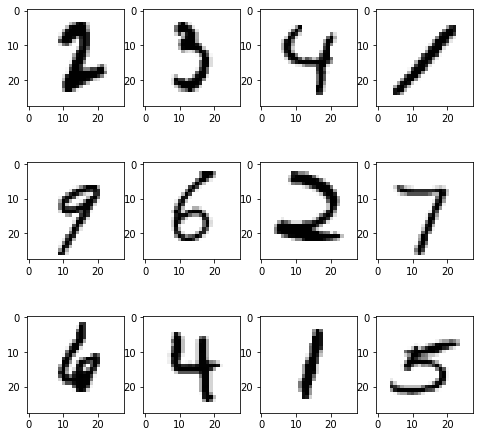

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Affichage d'une image
fig = plt.figure(figsize=(8, 8))
columns, rows = 4, 3
for i in range(1, columns*rows +1):
    img = X_train[np.random.randint(X_train.shape[0])][:,:,0]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray_r')
plt.show()

In [12]:
from google.colab import output, drive

iterations = 10000
batch_size = 16

drive.mount('/content/drive/', force_remount=True)
# save_dir = "/content/drive/MyDrive/Projets/Projet_GAN_basic/Generated_images_only_5/"
save_dir = "/content/drive/MyDrive/Projets/Projet_GAN_basic/Generated_images/"

Mounted at /content/drive/


In [1]:
import tensorflow as tf

def train_models(combined_images, labels,
                 random_latent_vectors, misleading_targets):

  # Entrainement du modèle discriminant
  dis_loss = model_discriminator.train_on_batch(combined_images, labels)

  # Entrainement du générateur
  gen_loss = model_gan.train_on_batch(random_latent_vectors, misleading_targets)

  return dis_loss, gen_loss

In [2]:
labels = tf.concat([tf.ones([16, 1]), tf.zeros([16, 1])], 0)

In [3]:
tf.random.uniform(shape=[labels.shape[0]], maxval=1)

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([0.98270404, 0.5274246 , 0.46728563, 0.4376676 , 0.8117541 ,
       0.20302176, 0.53890324, 0.32088995, 0.2932701 , 0.87763023,
       0.67813003, 0.4669273 , 0.57052064, 0.20796895, 0.5186658 ,
       0.5419513 , 0.53755856, 0.05552721, 0.6862651 , 0.9505439 ,
       0.4722371 , 0.69753754, 0.0807296 , 0.15294826, 0.6678928 ,
       0.71205556, 0.600471  , 0.64668393, 0.15325987, 0.17014694,
       0.8223244 , 0.04513454], dtype=float32)>

In [4]:
import pandas as pd

start = 0
vec_dis_loss, vec_gen_loss = [], []

for step in range(iterations):

  # Echantillonnage aléatoire des points de l'espace latent
  random_latent_vectors = tf.random.normal([batch_size, latent_dim])

  # Création d'images fausses
  generated_images = model_generator.predict(random_latent_vectors)

  # Combinaison des fausses images avec les authentiques
  stop = start + batch_size
  real_images = X_train[start:stop]
  combined_images = tf.concat([generated_images, real_images], 0)

  # Combinaison des labels
  labels = tf.concat([tf.ones([batch_size, 1]), tf.zeros([batch_size, 1])], 0)

  # Ajout de bruit sur les étiquettes
  labels += 0.05 * tf.random.uniform(shape=[labels.shape[0]], maxval=1)

  # Echantillonnage aléatoire des points de l'espace latent
  random_latent_vectors = tf.random.normal([batch_size, latent_dim])

  # Assemblage des etiquettes "authentique" pour l'entrainement du modèle génératif
  misleading_targets = tf.zeros([batch_size, 1])

  # Entrainement des modèles
  dis_loss, gen_loss = train_models(combined_images, labels, 
                                    random_latent_vectors, misleading_targets)
  
  vec_dis_loss.append(dis_loss)
  vec_gen_loss.append(gen_loss)

  start += batch_size
  if start > len(X_train) - batch_size:
    start = 0

  if step % 100 == 0:

    # Sauvegarde des poids du modèle
    # model_gan.save_weights('model_gan.h5')

    # Sauvegarde une image générée
    img = image.array_to_img(generated_images[0]*127.5 + 127.5, scale=False)
    img.save(os.path.join(save_dir, "generated_number_step" + str(step) + '.png'))

  output.clear()
  
  vec_epochs = list(range(step+1))

  mm_dis_loss = pd.Series(np.array(vec_dis_loss)).rolling(3).mean()
  mm_gen_loss = pd.Series(np.array(vec_gen_loss)).rolling(3).mean()

  plt.plot(vec_epochs, mm_dis_loss, label = "Discriminator")
  plt.plot(vec_epochs, mm_gen_loss, label = "Generator")
  plt.xlabel('Epochs')
  plt.ylabel('Loss (MM)')
  plt.title("Last step:" + str(step))
  plt.legend()
  plt.show()

NameError: ignored

In [ ]:
plt.plot(list(range(208)), vec_dis_loss, label = "Discriminator")
plt.plot(list(range(207)), vec_gen_loss, label = "Generator")
plt.xlabel('Epochs')
plt.ylabel('Loss (MM)')
plt.ylim(0, 2)
plt.title("Last step:" + str(step))
plt.legend()
plt.show()

Référence additionnelle sur le sujet:
- https://www.tensorflow.org/tutorials/generative/dcgan